In [4]:
import pandas as pd
import datetime as dt

# Load CSV
df = pd.read_csv("OnlineRetail.csv", encoding='ISO-8859-1')
# Remove rows with missing CustomerID
df = df[df['CustomerID'].notna()]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


# Set Reference Date for Recency

In [6]:
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)


# Calculate RFM Metrics

In [7]:
# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days, 
    'InvoiceNo': 'nunique',                                     
    'TotalPrice': 'sum'                                         
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


# Assign RFM Scores

In [8]:
# Score each metric
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4]).astype(int)

# Combine into one RFM Score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,2,0.00,1,2,1,121,4
1,12347.0,2,7,4310.00,4,4,4,444,12
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,3,1,4,314,8
4,12350.0,310,1,334.40,1,1,2,112,4


# Define Segments

In [9]:
def segment_customer(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal'
    elif score >= 5:
        return 'Potential'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm['Segment'].value_counts()


Segment
Champions    1719
Potential     992
Loyal         858
At Risk       803
Name: count, dtype: int64

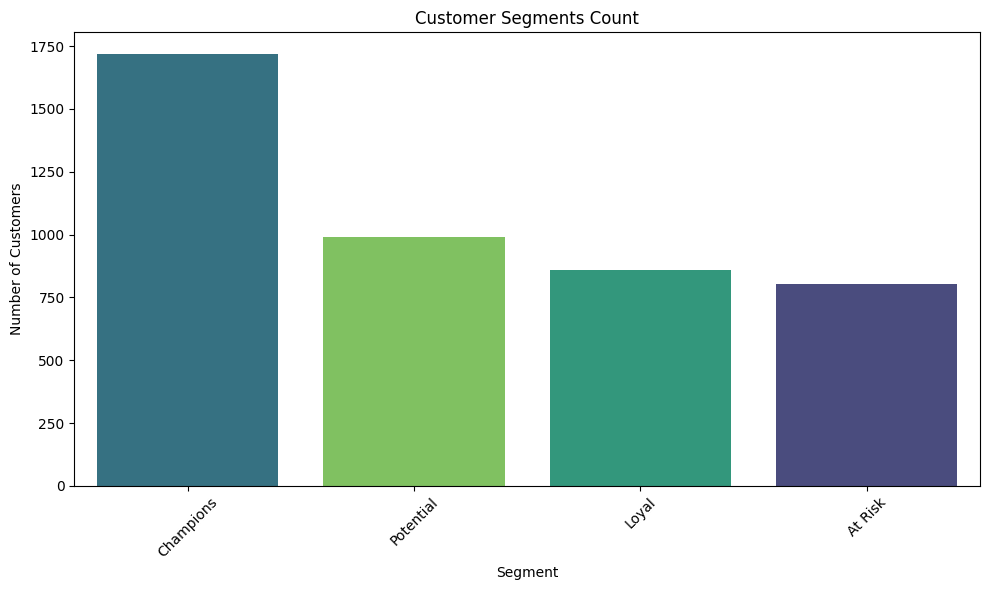

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the number of customers per segment
plt.figure(figsize=(10, 6))
sns.countplot(
    data=rfm,
    x='Segment',
    hue='Segment',  # Required to avoid deprecation warning
    order=rfm['Segment'].value_counts().index,
    palette='viridis',
    legend=False
)
plt.title('Customer Segments Count')
plt.ylabel('Number of Customers')
plt.xlabel('Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
